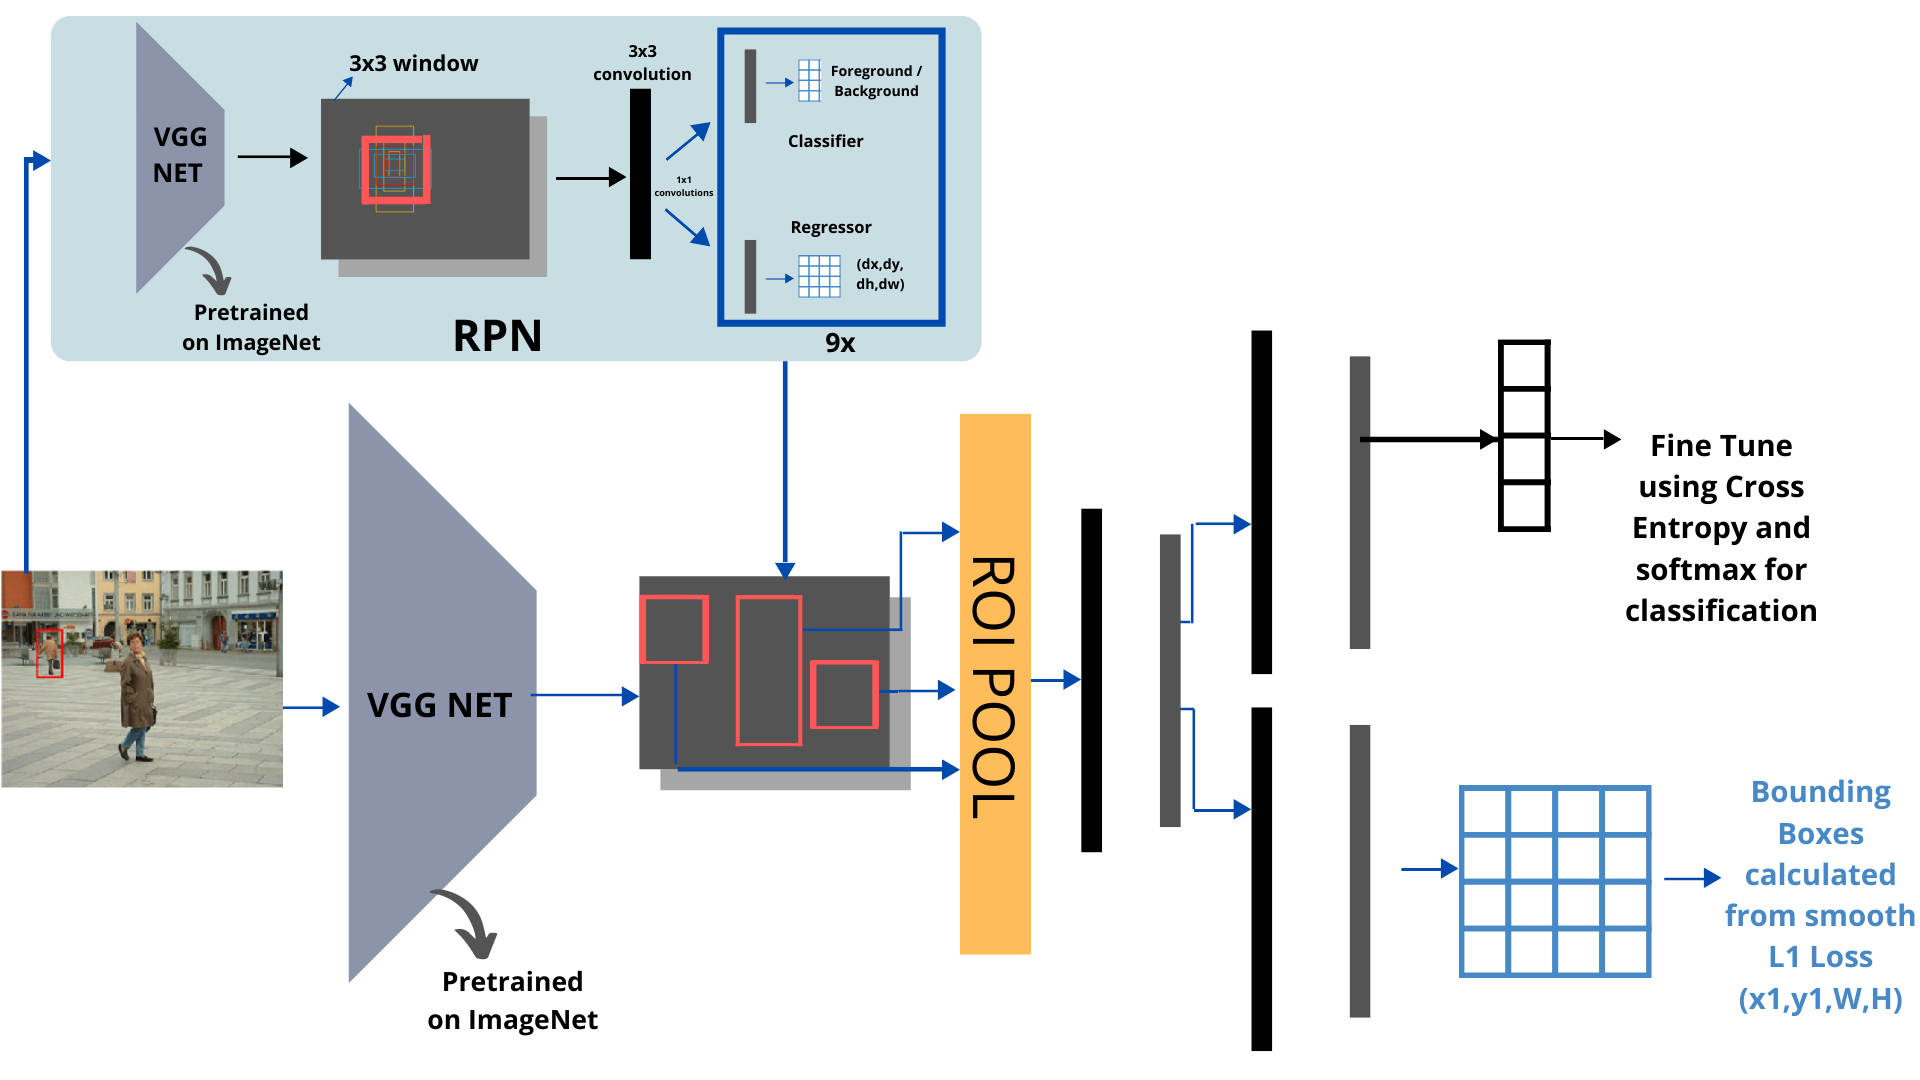

In [1]:
import os
import requests
import tarfile
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
import random
from torchvision.transforms import functional as F
from PIL import Image
from torchvision import transforms
import pandas as pd
from pytorch_lightning import seed_everything
import torchvision
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Download the Flickr27 Dataset**

In [2]:
def download_and_extract(url, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get the filename from the URL
    filename = os.path.join(destination_folder, url.split("/")[-1])

    # Download the file
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

    # Extract the contents of the tar.gz file
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall(destination_folder)

    # Remove the downloaded compressed file
    os.remove(filename)

In [3]:
dataset_url = "http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz"
    
destination_folder = "flickr_logos_dataset"

download_and_extract(dataset_url, destination_folder)

fname = 'flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

with tarfile.open(fname, 'r:gz') as tar:
    tar.extractall(destination_folder)

os.remove(fname)

## **Remove broken images and images having irrelevant Bounding Boxes**

In [4]:
def is_valid_image(img_path):
    try:
        Image.open(img_path).verify()
        return True
    except (IOError, SyntaxError):
        return False

def remove_broken_and_invalid_entries(folder_path, annotation_file_path):
    
    total_images_before = len(os.listdir(folder_path))
    
    with open(annotation_file_path, 'r') as file:
        total_entries_before = len(file.readlines())

    # Read the annotation file into a list
    with open(annotation_file_path, 'r') as file:
        annotations = file.readlines()

    # Filter out broken and invalid entries
    valid_annotations = []
    for annotation in annotations:
        parts = annotation.split()
        img_name, class_name, _, xmin, ymin, xmax, ymax = parts

        # Check if image is valid
        img_path = os.path.join(folder_path, img_name)
        if not is_valid_image(img_path):
            continue

        # Check if bounding box is valid
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
        if xmin >= xmax or ymin >= ymax:
            continue

        # If both checks pass, add the annotation to the valid list
        valid_annotations.append(annotation)

    # Update the annotation file
    with open(annotation_file_path, 'w') as file:
        file.writelines(valid_annotations)

    # Remove broken and invalid images
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            img_path = os.path.join(root, file)
            if not is_valid_image(img_path):
                os.remove(img_path)
            else:
                img_name = file
                annotation_exists = any(img_name in annotation for annotation in valid_annotations)
                if not annotation_exists:
                    print(img_path)
                    os.remove(img_path)

    # Count the total number of images after removal
    total_images_after = len(os.listdir(folder_path))
    
    total_entries_after = len(valid_annotations)

    print(f"Total number of entries before: {total_entries_before}")
    print(f"Total number of entries after Removal: {total_entries_after}")

    print(f"Total number of images before Removal: {total_images_before}")
    print(f"Total number of images after Removal: {total_images_after}")


In [5]:
folder_path = "/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images"
annotation_file_path = "/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"
remove_broken_and_invalid_entries(folder_path, annotation_file_path)

/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/3199286444.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/3907703753.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/3395884256.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/2214052591.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/3024711242.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/3386777357.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/3198284747.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/3407179088.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/323273572.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/3202786812.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/57857859.jpg
/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images/3346538277.jpg
/kaggle

## **Parameters**

In [6]:
WIDTH = 100
HEIGHT = 100
BATCH_SIZE = 16
VAL_SPLIT = 0.2
NUM_CLASSES = 27
LR = 0.001
CHECKPOINT_NAME = 'BestFasterRCNN'
ANNOTATION_FILE_PATH = '/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt'
QUERY_SET_PATH = '/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt'
MAIN_LOGO_FOLDER = '/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset_images'
MAX_EPOCHS = 100

## **Transform function for Image and BBoxes**

In [7]:

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [8]:
def collate_fn(batch):
        return tuple(zip(*batch))

## **Build the Dataset**

In [9]:
class Flickr27Dataset(Dataset):
    def __init__(self, root_folder, annotation_file, class_name_to_label ,transform=None):
        self.root_folder = root_folder
        self.annotations = annotation_file
        self.transform = transform
        self.ClasstoLabel = class_name_to_label
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_name = self.annotations.iloc[idx][0]
        image_path = f"{self.root_folder}/{image_name}"

        # Load image
        image = Image.open(image_path).convert("RGB")
        wt, ht = image.size
        image = image.resize((WIDTH, HEIGHT))
        image = np.array(image).astype(np.float32)
        image /= 255.0
        
        
        # Extract bounding box coordinates and class label
        xmin = self.annotations.iloc[idx][3]
        ymin = self.annotations.iloc[idx][4]
        xmax = self.annotations.iloc[idx][5]
        ymax = self.annotations.iloc[idx][6]
        
        # change bounding box as per resize
        
        xmin_corr = (xmin/wt)*WIDTH
        xmax_corr = (xmax/wt)*WIDTH
        ymin_corr = (ymin/ht)*HEIGHT
        ymax_corr = (ymax/ht)*HEIGHT
        
        
        box = [xmin_corr, ymin_corr, xmax_corr, ymax_corr]
        box = [float(coord) for coord in box]
        class_name = self.annotations.iloc[idx][1]
        class_label = self.ClasstoLabel[class_name]
         
        
        # Create target dictionary containing bounding box and class information
        target = {
            'image_id' : torch.tensor([idx]),
            'boxes' : torch.tensor([box], dtype=torch.float32),
            'labels' : torch.tensor([class_label], dtype=torch.int64),
        }
        
        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transform(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'])
 

        return image, target


## **Build the Dataloader**

In [10]:

class Flickr27DataModule(pl.LightningDataModule):
    def __init__(self, root_folder, annotation_file, batch_size=2, val_split=0.1):
        super(Flickr27DataModule, self).__init__()
        self.root_folder = root_folder
        self.annotation_file = annotation_file
        self.batch_size = batch_size
        self.val_split = val_split
        
    

    def setup(self, stage=None):
        # Read the annotation file into a DataFrame
        
        columns = ["imgname", "classname", "class", "xmin", "ymin", "xmax", "ymax"]
        annotations = pd.read_csv(self.annotation_file, delimiter=' ', header=None, names=columns, index_col=False)

        class_names = annotations['classname'].unique()
        
        class_name_to_label = {class_name: label for label, class_name in enumerate(class_names)}
        
        # Split the dataset into training and validation sets
        train_data, val_data = train_test_split(annotations, test_size=self.val_split, random_state=42)

      
        self.train_dataset = Flickr27Dataset(
            root_folder=self.root_folder,
            annotation_file=train_data,
            class_name_to_label=class_name_to_label,
            transform=get_train_transform())

        self.val_dataset = Flickr27Dataset(
            root_folder=self.root_folder,
            annotation_file=val_data,
            class_name_to_label=class_name_to_label,
            transform=get_valid_transform())
        

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,collate_fn=collate_fn,shuffle=True,num_workers=15)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,collate_fn=collate_fn,shuffle=False,num_workers=15)

    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,collate_fn=collate_fn,shuffle=False,num_workers=15)


## **Build the Model**

In [11]:
class FasterRCNNLightning(pl.LightningModule):
    def __init__(self, num_classes, lr):
        super(FasterRCNNLightning, self).__init__()
        
        self.lr = lr
        self.validation_step_outputs = []

        # Load a pre-trained Faster R-CNN model
        self.model = fasterrcnn_resnet50_fpn(pretrained=True)

        # Modify the classifier head for your number of classes
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # Create the Flickr27Dataset instance

    def forward(self, x, target=None):
        if target is not None:
            return self.model(x, target)
        else:
            return self.model(x)


    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images, targets)
        loss = sum(loss for loss in outputs.values())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
        
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

    

In [12]:
seed_everything(42, workers=True)

42

In [13]:
model = FasterRCNNLightning(num_classes = NUM_CLASSES, lr = LR)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 58.7MB/s] 


In [14]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = CHECKPOINT_NAME,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

In [15]:
data_module = Flickr27DataModule(root_folder = MAIN_LOGO_FOLDER,
                                annotation_file = ANNOTATION_FILE_PATH,
                                batch_size = BATCH_SIZE,
                                val_split = VAL_SPLIT)

data_module.setup()

## **Training of Model**

In [16]:
trainer = pl.Trainer(devices=-1, 
                  accelerator="gpu",
                  check_val_every_n_epoch=5,
                  max_epochs=MAX_EPOCHS)

In [17]:
trainer.fit(model=model,datamodule=data_module)

Training: |          | 0/? [00:00<?, ?it/s]

In [19]:
columns = ["imgname", "classname", "class", "xmin", "ymin", "xmax", "ymax"]
data_df = pd.read_csv(ANNOTATION_FILE_PATH, sep=' ', header=None, names=columns,index_col=False)
data_df['full_path'] = MAIN_LOGO_FOLDER + '/' + data_df['imgname']

In [20]:
class_names = data_df['classname'].unique()        

In [21]:
def get_transform():
    return A.Compose([
        ToTensorV2(p=1.0)])

In [22]:
   
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

## **Prediction**

In [23]:


def predplot_img_bbox(iou_thresh=0.1):
    all_files = os.listdir(MAIN_LOGO_FOLDER)

    random_image_file = random.choice(all_files)

    path = os.path.join(folder_path, random_image_file)

    image = Image.open(path).convert("RGB")
    
    image = image.resize((WIDTH, HEIGHT))
    
    
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    
    a.imshow(image)
    plt.axis('off')
    
    img = np.array(image).astype(np.float32)
    img /= 255.0
    
    img = get_transform()(image=img)
    
    image_tensor = img['image'].unsqueeze(0) 
    
    model.eval()
    with torch.no_grad():
        prediction = model.forward(image_tensor.to(model.device))[0]
        
    prediction = apply_nms(prediction, iou_thresh=0.1)

            
    for box, label in zip(prediction['boxes'].cpu(), prediction['labels'].cpu()):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]

        # Create a rectangle
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle to the axis
        a.add_patch(rect)

        # Add label text near the rectangle
        class_label = class_names[label.item()]
        label_text = f'Class: {class_label}'  # Assuming labels are tensor, convert to item()
        a.text(x, y - 5, label_text, color='g',weight='bold')
    plt.show()

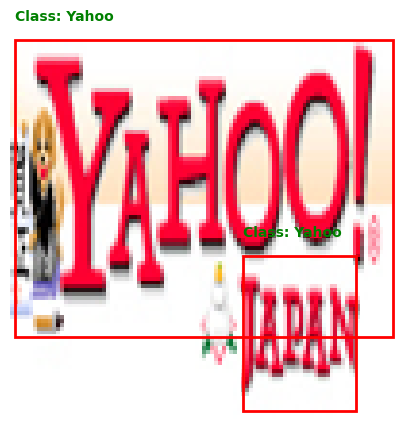

In [25]:
predplot_img_bbox(iou_thresh=0.1)